# World Data League 2021 🚲

**Sub:** Predicting the demand for shared bicycles in Medellín, CO<br>
**Team:** NextEpoch

## Notebook Template (WDL content)

This notebook is one of the mandatory deliverables when you submit your solution (alongside the video pitch). Its structure follows the WDL evaluation criteria and it has dedicated cells where you can add descriptions. Make sure your code is readable as it will be the only technical support the jury will have to evaluate your work.
The notebook must:
*   💻 have all the code that you want the jury to evaluate
*   🧱 follow the predefined structure
*   📄 have markdown descriptions where you find necessary
*   👀 be saved with all the output that you want the jury to see
*   🏃‍♂️ be runnable

## External links and resources 🔗
All used data was acquired through the following links:

1. Metro link: https://wdl-data.fra1.digitaloceanspaces.com/medellin/medellin_metro_stations_and_routes.zip
2. Bike load csv: https://wdl-data.fra1.digitaloceanspaces.com/medellin/bike_loans.zip
3. Bus routes: https://wdl-data.fra1.digitaloceanspaces.com/medellin/medellin_bus_routes.zip
4. Weather API: https://openweathermap.org/history
5. HERE API Route calculation: https://route.ls.hereapi.com/routing/7.2/calculateroute.json

## Introduction 👩‍🏫
**Overview:**
During this 2-week’s sprint we are working on historical bike rental data from the provider 'enCicla' in Medellin, Colombia. The company is government owned and provides over 1,600 bicycles distributed in over 101 stations in Medellin and its greater area. The bike rental is for free for everyone who is registered in the system. However, it has operating hours at which the rentals are permitted. 

_from challenge description_
<blockquote>
One of the main challenges that the system has is to keep bicycles available by the time the user approaches the station to make a loan and have anchor points available for the moment the user wants to deliver the borrowed bike.
</blockquote>

The heart of the provided **data** is a transaction log for each bike pick-up and drop-off since 2014. In total there are aprox. 14m rows in the data set. One of the main challenges is to preprocess the data and make it usable for a system balance prediction model. The data includes pre- and post covid rentals. We decided to narrow it down to a pre covid analysis. 

## Development ⚙️

### Imports (libraries) 📚

In [91]:
## TABULAR
import pandas as pd 
import numpy as np
import matplotlib

## GEO
import geopandas as gpd
import fiona
from folium.plugins import MarkerCluster, HeatMap, BeautifyIcon
from folium.map import LayerControl, Layer, FeatureGroup
from folium.vector_layers import Circle, CircleMarker
from shapely.geometry import LineString, Point
from shapely import wkt


## DATA
import os
import zipfile
from collections import Counter
import re
from datetime import datetime
import requests
from dotenv import load_dotenv, find_dotenv
import ast
import datetime as dt

## VIS
from ipywidgets import interact, interactive, fixed, interact_manual, IntSlider
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.tsa
import branca

### Data Extraction 🏗

The provided data comes in different types of file extensions.  <br> 
Some of the files are **very big** and for this reason is easier to call them just when we need them. <br>
For this reason we are going to create a class that will be able to read and extract the data, already operating the first **cleaning** steps.

In [6]:
gpd.io.file.fiona.drvsupport.supported_drivers['KML'] = 'rw' # necessary for kml files
class Databases:
    def __init__(self, csv, anva, smm, metro): # pass the file names stored in 'raw_data/'
        self.csv = csv
        self.anva = anva 
        self.smm = smm
        self.metro = metro

    def extract_csv(self):
        # bike rental logs
        file = pd.read_csv(f'data/bike_loans/{self.csv}', sep=';').drop(columns=['Importe', 
                                                                        'DescripcionImporte', 
                                                                        'operario']) # drop irrelevant columns
        file['Fecha_Prestamo'] = pd.to_datetime(file['Fecha_Prestamo'])
        file['Fecha_Devolucion'] = pd.to_datetime(file['Fecha_Devolucion'])
        return file
        
    
    def extract_anva(self):
        # regional bus routes
        bus_routes_AMVA = gpd.GeoDataFrame()
        for root, dirs, files in os.walk(f'data/bus_routes/medellin_bus_routes/{self.anva}'):
            for file in files:
                path = os.path.join(root, file)
                df = gpd.read_file(path, driver='KML')
                bus_routes_AMVA = gpd.GeoDataFrame(pd.concat([bus_routes_AMVA, df], ignore_index=True))
        return bus_routes_AMVA
    
    def extract_smm(self):
        # municipal bus routes medellin
        smm_bus_routes = gpd.GeoDataFrame()
        for root, dirs, files in os.walk(f'data/bus_routes/medellin_bus_routes/{self.smm}'):
            for file in files:
                path = os.path.join(root, file)
                df = gpd.read_file(path, driver='KML')
                smm_bus_routes = gpd.GeoDataFrame(pd.concat([smm_bus_routes, df], ignore_index=True))
        return smm_bus_routes
    
    def extract_metro(self):
        # metro routes
        metro_routes = gpd.GeoDataFrame()
        for root, dirs, files in os.walk(f'data/medellin_metro/{self.metro}'):
            for file in files:
                path = os.path.join(root, file)
                print(path)
                if path.endswith('.kmz'):
                    kmz = zipfile.ZipFile(path, 'r')
                    kml = kmz.open('doc.kml', 'r')
                    df = gpd.read_file(kml, driver='KML')
                    metro_routes = gpd.GeoDataFrame(pd.concat([metro_routes, df], ignore_index=True))
        return metro_routes

In [10]:
databases = Databases('bike_loans.csv','Kml Ruta AMVA','kml Ruta SMM','medellin_metro_stations')

In [26]:
bikes = databases.extract_csv() # for our preliminary analysis we only need the bike logs (no public transportation)
bikes.dtypes

Id_Historico_Prestamo               int64
Id_Usuario                          int64
Id_Tag_Bicicleta                   object
Fecha_Prestamo             datetime64[ns]
Fecha_Devolucion           datetime64[ns]
Id_Aparcamiento_Origen              int64
Posicion_Origen                     int64
Id_Aparcamiento_Destino           float64
Posicion_Destino                  float64
Num_Bici_Hist                     float64
dtype: object

### Preliminary Analysis 📊

We can start our analy|sis with a general description of the dataset. <br>
**NB**: In our dataset we are dealing with all categorical features or timeseries: there is no need to run ```describe()``` 

#### Bike usage

- Id_Tag_Bicicleta : column regarding unique id of each bicycle 
***let's have a look on how many times the same bike is used (how many times the unique id is present in the df)**

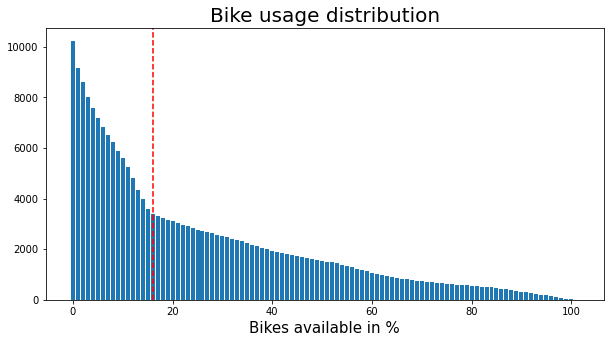

In [28]:
# plot the usage of unique bikes and its distribution
plt.figure(figsize=(10,5))
plt.title('Bike usage distribution', size=20)
counts = bikes.Id_Tag_Bicicleta.value_counts()[::66]
y_pos = np.arange(len(counts))
plt.bar(y_pos, counts)
plt.xlabel('Bikes available in %', size=15)
# plt.text(x=22, y=6000, s=f'Cutoff: 20% of highest usage', size='x-large')
plt.axvline(16, color='r', linestyle='--')

plt.show()

**Note**<br>
There is a strong elbow visible between the 10th and 20th percentile. This could either derive from a highly rising bike usage over the years and thus, underrepresented usage for depreciated bikes. It could also mean that some bikes are significantly standing around too much because they are put to the wrong stations at wrong times and therefore not used enough. 

In [29]:
print(f'In total we have {len(bikes.Id_Tag_Bicicleta.unique())} unique bikes over all recorded time')

In total we have 6698 unique bikes over all recorded time


#### Rental distribution

In our dataset we have information about the bike itself, the station of arrival and departures and the costumer. To characterized all this information we have also 2 time series: ```Fecha_Prestamo``` & ```Fecha_Devolucion``` 

<br>
Thanks to these we can have an idea of the time in which the bike are more used, which routes are more popular during a certain range of time and also how the data collected has changed during the years, according maybe to the change in habits of the population. 

In [30]:
# Extracting just the hour: 
bikes['hour_init']= bikes['Fecha_Prestamo'].dt.hour
bikes['hour_end']=bikes['Fecha_Devolucion'].dt.hour
bikes.head(5)

,Id_Historico_Prestamo,Id_Usuario,Id_Tag_Bicicleta,Fecha_Prestamo,Fecha_Devolucion,Id_Aparcamiento_Origen,Posicion_Origen,Id_Aparcamiento_Destino,Posicion_Destino,Num_Bici_Hist,hour_init,hour_end
0,6501462,18701,000017B00743,2017-06-21 14:22:11,2017-06-21 14:38:29,8,1,43.0,1.0,929.0,14,14
1,6501318,41811,000017AFF83C,2017-06-21 14:07:18,2017-06-21 14:39:06,56,6,54.0,NaN,1612.0,14,14
2,6501489,96620,000017AFFB6F,2017-06-21 14:25:11,2017-06-21 14:39:07,36,25,9.0,13.0,1679.0,14,14
3,6501001,16055,0000182A3B7B,2017-06-21 13:35:52,2017-06-21 14:39:22,8,1,9.0,6.0,1076.0,13,14
4,6501421,6431,000017AFE810,2017-06-21 14:17:56,2017-06-21 14:39:26,56,14,54.0,NaN,1176.0,14,14


The highest usage of bikes is at 17h and 7h


/Users/moritzgeiger/.pyenv/versions/3.8.6/envs/lewagon/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


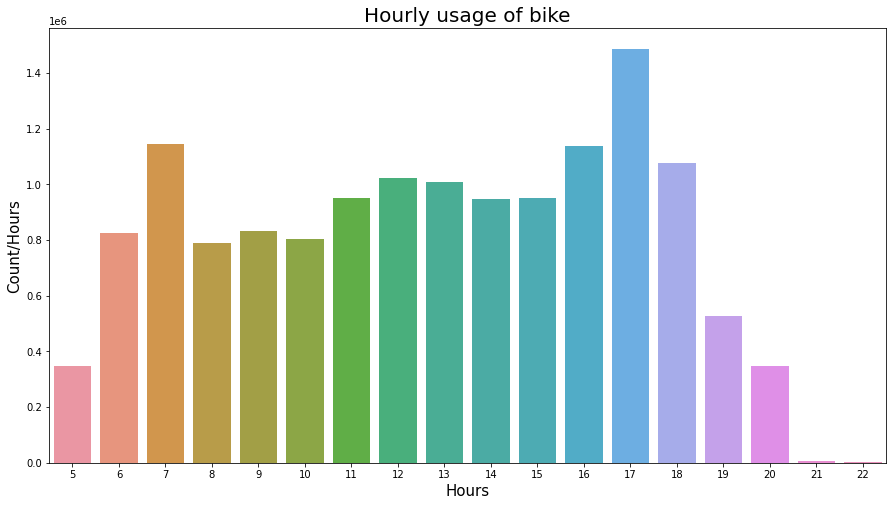

In [31]:
# plot the mean distribution of bike rentals over the day
plt.figure(figsize=(15,8))
hours = pd.DataFrame(bikes.hour_init.value_counts())
hours = hours.drop(index=[1,2,3,4,23,0]) # out of operation hours
sns.barplot(hours.index,hours.hour_init)
plt.title('Rental distribution over the day', size=20)
plt.xlabel('Hours', size=15)
plt.ylabel('Count/Hours', size=15)
print(f'The highest usage of bikes is at 17h and 7h')

#### Bike Routes

In [47]:
# create a 'routes' feature with a string <start>_<finish>
bikes = bikes.dropna()
bikes['routes'] = bikes.apply(lambda x: f'{x.Id_Aparcamiento_Origen}_{int(x.Id_Aparcamiento_Destino)}', axis=1)

<ipython-input-47-3f998b9f8ef4>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bikes['routes'] = bikes.apply(lambda x: f'{x.Id_Aparcamiento_Origen}_{int(x.Id_Aparcamiento_Destino)}', axis=1)


- We can now try to understand the routes depending on the our of the day.
- During all the analysis we will focus on the hours as main indicator as our target regard the best distribution of bikes **xhour**

In [48]:
# grouping by hour
bikes['hour'] = bikes.Fecha_Prestamo.dt.hour
agg = {'Id_Aparcamiento_Origen':'count', 
      'routes': lambda x: list(x)}
routes_by_hr = bikes.groupby('hour').agg(agg).rename(columns={'Id_Aparcamiento_Origen':'count_rentals'})

<ipython-input-48-8dfc62310054>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bikes['hour'] = bikes.Fecha_Prestamo.dt.hour


In [54]:
# count the amount of occuring routes per hour (counting the ocurrences in the lists)
routes_dict = {}
for c, row in routes_by_hr.iterrows():
    routes_dict[c] = dict(Counter(row.routes))

routes_usage = pd.DataFrame.from_dict(routes_dict)

In [55]:
# grouping by hour
agg = {'Id_Aparcamiento_Origen':'count', 
      'routes': lambda x: list(x)}
routes_by_hr = bikes.groupby('hour_init').agg(agg).rename(columns={'Id_Aparcamiento_Origen':'count_rentals'})

##### Route usage graph

Let's see which routes were used most in which times of the day.

In [56]:
# take the top3 routes per hour
rank_routes = {}
for hour in routes_usage.columns:
    top3 = dict(routes_usage[hour].sort_values(ascending=False)[:3])
    rank_routes[hour] = top3
rank_routes_df = pd.DataFrame(rank_routes).T

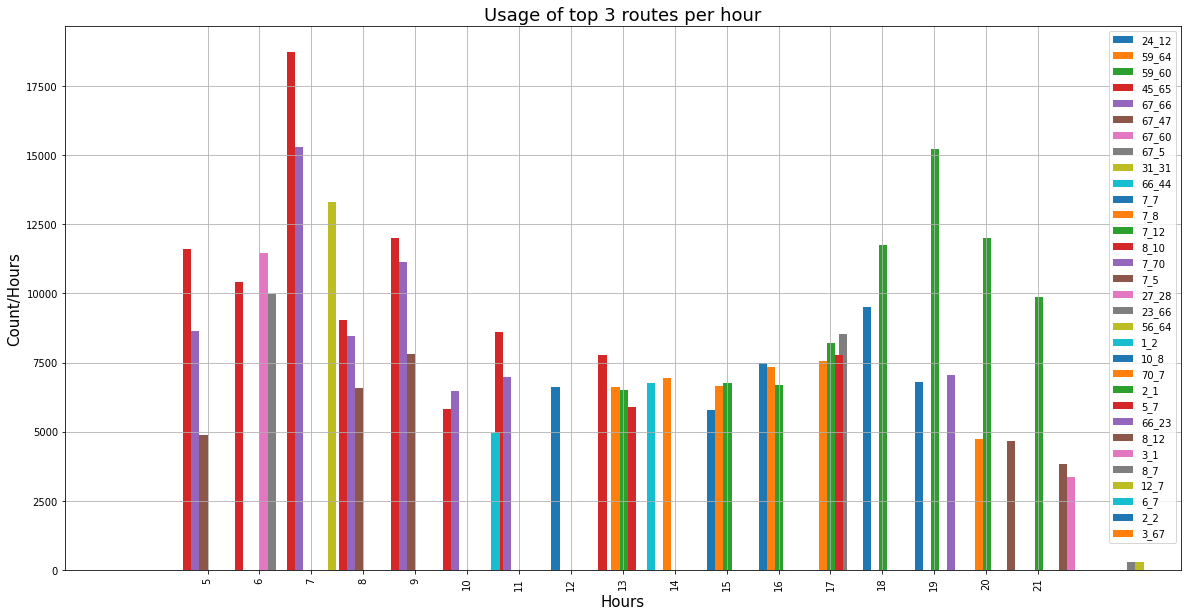

In [59]:
rank_routes_df.loc[5:21].plot(kind='bar', figsize=(20,10), width=5, stacked=False, align='center') # only take operating hours
plt.title('Usage of top 3 routes per hour', size=18)
plt.xlabel('Hours', size=15)
plt.ylabel('Count/Hours', size=15)
plt.grid()
plt.show()

**Note**<br>
- In the morning hours the route ```8_10``` is represented in high numbers followed by ```7_70```
- In the evening hours there are more ```2_1``` and ```10_8``` rentals recorded
- Noons and afternoons have a stable distribution of ```70_7``` (returns of the mornings)
- Way less people go back the same way they came from (```8_10``` vs. ```10_8```)

##### Road usage map

The routes balance can also be visualized in a **map.**

In order to show the routes in a more realistic way, we transformed them into routes (LineStrings) computed by the ```HERE API```. The code for this you can find here in the [appendix](#Calculate-routes-with-HERE-API).

In [76]:
# reload file after using HERE API
# already contains coordinates
routes_usage_x = pd.read_csv('data/routes_usage.csv', 
                             index_col=0, 
                             converters={'start_coord':ast.literal_eval}).dropna(subset=['geometry'])
routes_usage_x = gpd.GeoDataFrame(routes_usage_x)
routes_usage_x['geometry'] = routes_usage_x['geometry'].apply(wkt.loads)

In [77]:
# check for valid coords
(routes_usage_x.geometry == routes_usage_x.geometry).sum()

5720

In [88]:
# plot route density and station demand
def mapa(hour, show_routes, show_stations):
    hour = str(hour) # col names are read in str
    m = folium.Map([6.25, -75.58], zoom_start=13, tiles='cartodbpositron')
    
    hour_df = routes_usage_x[routes_usage_x[hour] == routes_usage_x[hour]][[hour, 'start_id', 'start_coord', 'geometry']]
    hour_df = hour_df[hour_df.geometry == hour_df.geometry].sort_values(by=hour, ascending=False)
    hour_df = hour_df.dropna().head(100)
    hour_df = gpd.GeoDataFrame(hour_df)
    
    # routes
#     cmap = matplotlib.cm.get_cmap('BuPu')
    cmap = branca.colormap.linear.BuPu_09.scale(0, 1)
    routes = FeatureGroup(name='Routes', show=show_routes)
    for c, row in hour_df.iterrows():
        # routes
        hexa = matplotlib.colors.to_hex(cmap(row[hour]/hour_df[hour].max()))
        xy = row.geometry.coords.xy
        coords = [[x[i] for x in [xy[1], xy[0]]] for i in range(len(xy[0]))]
        folium.PolyLine(coords, 
                        color=hexa, 
                        weight=10, 
                        tooltip=f'Route: {c}',
                        opacity=.3).add_to(routes)
    
    # circles
    pickup_df = hour_df.groupby('start_id').agg({hour:'sum', 'start_coord':'first'})
    cmapa = branca.colormap.linear.YlOrRd_09.scale(0, 1)
#     cmapa = matplotlib.cm.get_cmap('YlOrRd')
    stations = FeatureGroup(name='Stations', show=show_stations)
    for c, row in pickup_df.iterrows():
        size = (np.sqrt(row[hour])/19)**2
        hexe = matplotlib.colors.to_hex(cmapa(row[hour]/hour_df[hour].max()))

        CircleMarker((row.start_coord[1],row.start_coord[0]), 
                     radius=size, 
                     fill=True, 
                     tooltip=f'Station: {c}', 
                     color=hexe,
                     weight=0,
                     fill_opacity=.2
                    ).add_to(stations)
    
    # add layer stations to m
    cmapa.caption = 'Relative demand per station and hour of the day'
    cmapa.add_to(m)
    stations.add_to(m)
    
    # add layer routes to m
    routes.add_to(m)
    cmap.caption = 'Density of route usage per hour of the day'
    cmap.add_to(m)
    LayerControl().add_to(m)
    return m
title = ' Density flow daily bike usage '
print (title.center(110, '#'))
print('\nMove \'hour\' bar to see the flow change')
interact(mapa, hour=IntSlider(min=5, max=21, step=1, value=8), show_routes=True, show_stations=True)

####################################### Density flow daily bike usage ########################################

Move 'hour' bar to see the flow change


interactive(children=(IntSlider(value=8, description='hour', max=21, min=5), Checkbox(value=True, description=…

<function __main__.mapa(hour, show_routes, show_stations)>

**Note**<br>
The data for the circles of stations is beautified for better displaying purposes.
We can clearly see what has been described in the previous [graph](#Route-usage-graph). The most popular destinations are the three campuses of universities in the city of Medellin.
- Universidad Pontificia Bolivariana (Station: 10)
- Universidad Nacional de Colombia (Station: 70)
- Universidad de Antioquia (Stations: 2 & 3)

The biggest demand for bikes is visible in the two Metro stations: 
- Suramericana (Station: 7)
- Estadio (Station: 8)

#### Rental behavior

To understand the rental behavior it is important to look at the rental details. How are the 
- how many times were bikes returned to the **same** station?
- how many times were bikes rented **less** than 2 mins?

In [60]:
bikes['timespan_min'] = (bikes.Fecha_Devolucion - bikes.Fecha_Prestamo).dt.seconds/60

<ipython-input-60-13de74d111a5>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bikes['timespan_min'] = (bikes.Fecha_Devolucion - bikes.Fecha_Prestamo).dt.seconds/60


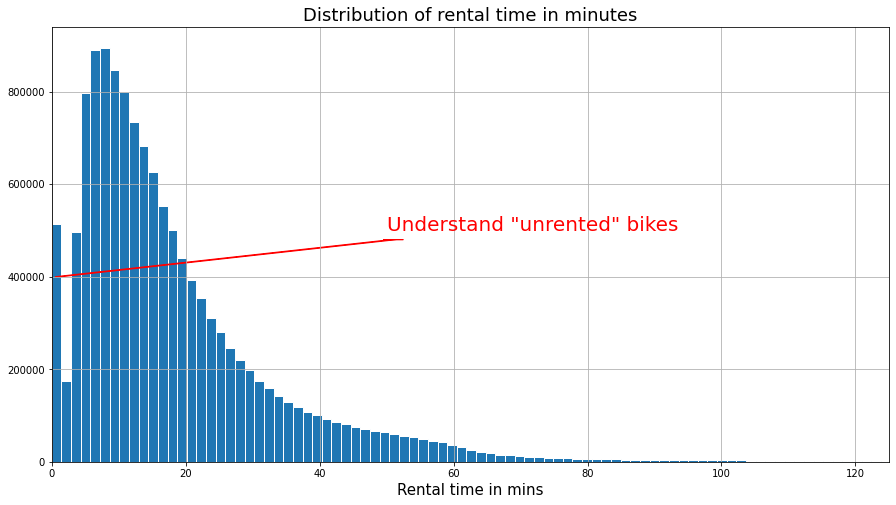

In [61]:
# plot the time spans of bike rentals
bikes.timespan_min.hist(bins=1000, figsize=(15,8), edgecolor='white')
plt.xlim(0,125)
plt.title('Distribution of rental time in minutes', size=18)
plt.text(50, 500000, s='Understand "unrented" bikes', c='r', rotation='horizontal', fontsize=20)
plt.arrow(1, 400000, 50, 80000, color='r', width=1)
plt.xlabel('Rental time in mins', size=15)
plt.show()

In [62]:
# re split the df to see start and finish ids separately
routes_usage['start_id'] = routes_usage.index.map(lambda x: x.split('_')[0])
routes_usage['finish_id'] = routes_usage.index.map(lambda x: x.split('_')[1])
routes_usage['no_move'] = routes_usage.start_id == routes_usage.finish_id # tag routes which returned to the same station

/Users/moritzgeiger/.pyenv/versions/3.8.6/envs/lewagon/lib/python3.8/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/Users/moritzgeiger/.pyenv/versions/3.8.6/envs/lewagon/lib/python3.8/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


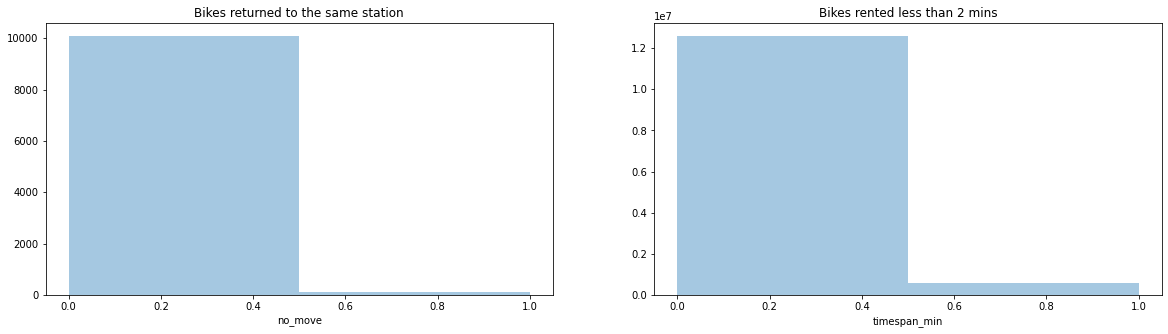

In [63]:
# how many times were bikes returned to the same station?
# how many times were bikes rented less than 2 mins?
plt.figure(figsize=(20,5))
plt.subplot(1,2,1)
sns.distplot(routes_usage.no_move, bins=2, kde=False)
plt.title('Bikes returned to the same station')
plt.subplot(1,2,2)
under_2 = bikes.timespan_min < 2
sns.distplot(under_2, bins=2, kde=False)
plt.title('Bikes rented less than 2 mins')
plt.show()

**Note**<br>
The distribution of rentals to the same station is rather small but it is of course likely for people to drop off bikes at the same station as they picked them up. That data should be kept in the data set.

### Pandemic analysis 😷

In the last year our habits changed a lot due to the pandemic we are dealing day by day with. For this reason we cannot avoid to take this factor into account.

**Let's see how our data changed before and after the spreading of the Corona Virus:**

In [64]:
bikes['year'] = bikes.Fecha_Prestamo.dt.year
evolution_bikes = {}
for year in sorted(bikes.year.unique())[::-1]:
    df_filter = bikes[bikes.year == year]
    df_filter_prev = bikes[bikes.year == year-1]
    bikes_ = df_filter.Id_Tag_Bicicleta.unique()
    bikes_prev = df_filter_prev.Id_Tag_Bicicleta.unique()
    count_up = len([bike for bike in bikes_ if bike not in bikes_prev])
    count_down = -len([bike for bike in bikes_prev if bike not in bikes_])
    evolution_bikes[year] = {'loss': count_down, 'win': count_up}

<ipython-input-64-1e55cde6d23a>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bikes['year'] = bikes.Fecha_Prestamo.dt.year


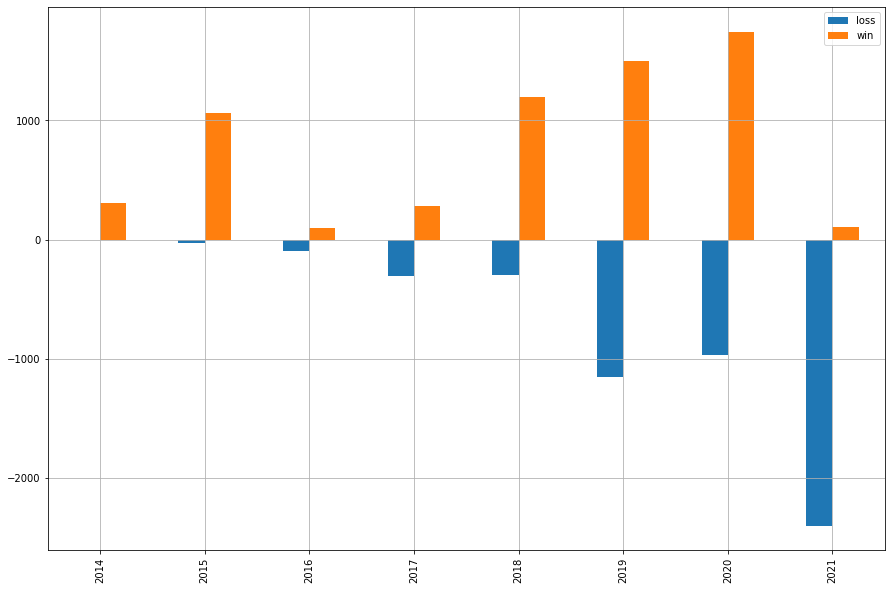

In [65]:
pd.DataFrame(evolution_bikes).T.sort_index().plot(kind='bar', figsize=(15,10))
plt.grid()

**Note**<br>
we can see that a lot of bikes stopped appearing in 2021. The highest investments for new bikes have been made in 2020.

**What about route exploration by users**

In [66]:
evolution_routes = {}
for year in sorted(bikes.year.unique())[::-1]:
    df_filter = bikes[bikes.year == year]
    df_filter_prev = bikes[bikes.year == year-1]
    routes_ = df_filter.routes.unique()
    routes_prev = df_filter_prev.routes.unique()
    count_up = len([route for route in routes_ if route not in routes_prev])
    count_down = -len([route for route in routes_prev if route not in routes_])
    evolution_routes[year] = {'loss': count_down, 'win': count_up}

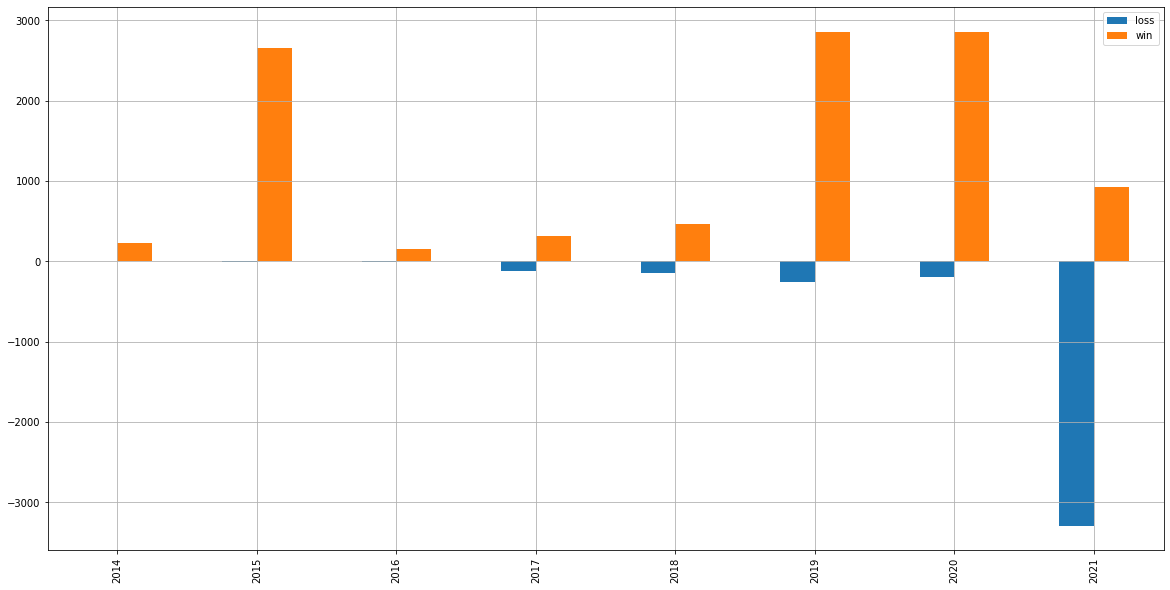

In [67]:
pd.DataFrame(evolution_routes).T.sort_index().plot(kind='bar', figsize=(20,10))
plt.grid()

**Note**<br>
In 2019 and 2020 a lot of new routes were explored by the bike users. This might be due to more private and recreational use of bikes during covid. 

**Did the total of rentals change during the years?**

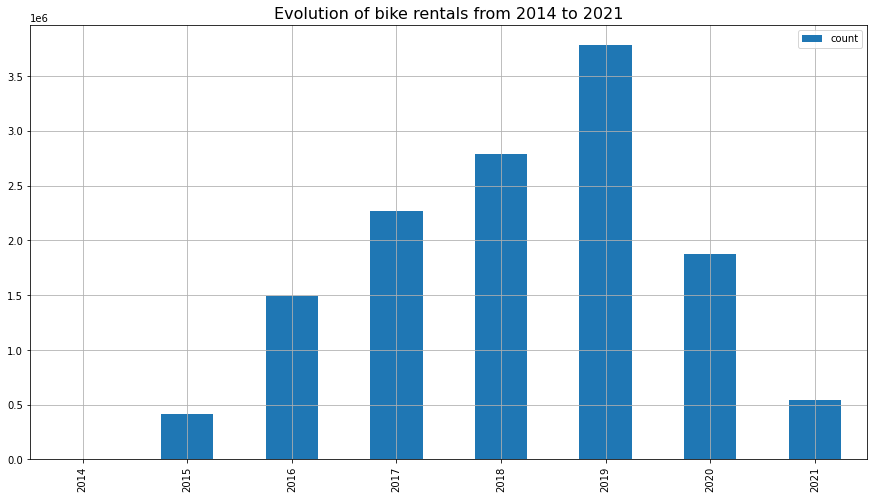

In [68]:
# calculate evolution of rentals
evolution_rentals = {}
for year in sorted(bikes.year.unique()):
    df_filter = bikes[bikes.year == year]
    count = df_filter.Id_Historico_Prestamo.count()
    evolution_rentals[year] = count
evolution_rentals_df = pd.DataFrame.from_dict(evolution_rentals, orient='index').rename(columns={0:'count'})
evolution_rentals_df.plot(kind='bar', figsize=(15,8))
plt.grid()
plt.title("Evolution of bike rentals from 2014 to 2021", size=16)
plt.show()

**Rentals plummet in 2020 and 2021.**
1. we cannot run a model without taking this real world event into account
2. we decide to split the data and work just on the pre-pandemic information to get a more normalized prediction model.

**Split of dataframe**

In [69]:
bikes_nocov = bikes[bikes.Fecha_Devolucion <= '31/12/2019']

In [72]:
print(f'Pre pandemic data with no nan values amounts to \n{bikes_nocov.shape[0]} rows.')

Pre pandemic data with no nan values amounts to 
10737486 rows.


### Data Preparation 🧑‍💻

We are building a model to predict the demand of rental bicycles for each station for any time in the future in the city of Medellin, CO.<br>
For that, we need to compute:<br>
1. the actual amount of bikes available at each station for each hour of the year.
2. we will add weather data for each hour of the year because we believe that weather has an impact on bike usage. 

#### Compute bike count per station per hour

In [89]:
# filter to 2019 data => most representative year
bikes_19 = bikes[bikes.Fecha_Devolucion.dt.year == 2019].reset_index()
bikes_19['Id_Aparcamiento_Destino'] = bikes_19['Id_Aparcamiento_Destino'].astype(int)
# split the previous data (needed for init state of bikes)
bikes_pre = bikes[bikes.Fecha_Devolucion.dt.year < 2019].reset_index()
bikes_pre['Id_Aparcamiento_Destino'] = bikes_pre['Id_Aparcamiento_Destino'].astype(int)
bikes_pre = bikes_pre[['Id_Tag_Bicicleta', 'Fecha_Devolucion', 'Id_Aparcamiento_Destino']].dropna()
# get all unique stations
unique_stations = pd.read_csv('data/station_location_with_id.csv', sep=';').drop(columns=['photo', 'webDescription'])


In [92]:
# assign df a individual hour of the year per row
def get_hr(x):
    time = x
    hour = dt.datetime(time.year, time.month,time.day,time.hour)
    return hour
    
bikes_19.loc[:,'hour'] = bikes_19.Fecha_Devolucion.apply(get_hr)

In [93]:
# make sure df is sorted chronologically
bikes_19 = bikes_19.sort_values(by='Fecha_Devolucion')

# list all the appearing bikes and stations per individual hour of the year
bikes_19_by_hour = bikes_19.copy().groupby('hour').agg({'Id_Tag_Bicicleta':lambda x: list(x), 
                                                        'Id_Aparcamiento_Destino':lambda x: list(x),
                                                        'Id_Aparcamiento_Origen':lambda x: list(x)})

# compute the init state of all bikes prior to 2019 to get a starting balance of bikes
# we assume that the bike in its last position wasn't 'touched', thus remained in the station until the 02.01.2019
bikes_pre = bikes_pre.sort_values(by='Fecha_Devolucion', ascending=False) # walk backwards through df to find 'last' position of each bike
stations_init_df = bikes_pre.groupby('Id_Tag_Bicicleta').agg({'Id_Aparcamiento_Destino':'first'}) # first means last in this case

# count the bikes at the stations (and pad the non appearing ones)
stations_init_pre = Counter({i:0 for i in unique_stations.ID})
stations_init_pre.update(Counter(dict(stations_init_df.Id_Aparcamiento_Destino.value_counts())))

In [94]:
# only keep the _last_ entry of a bike per hour (dict will overwrite intermediate movements)
# we will count pick-up and drop-off in the SAME time, since the avg. renting duration is about 10 mins. 
bikes_19_by_hour['bikes_loc'] = None
for c, row in bikes_19_by_hour.iterrows():
#     print(c) # check progress
    dct = {}
    for i, bike in enumerate(row.Id_Tag_Bicicleta):
        dct[bike] = (row.Id_Aparcamiento_Destino[i], row.Id_Aparcamiento_Origen[i]) # create route dict for each bike in the hour
    bikes_19_by_hour.at[c, 'bikes_loc'] = dct

# count the pickups and drop offs for each station per hour
bikes_19_by_hour['station_movement'] = None
for c, row in bikes_19_by_hour.iterrows():
    stations = row.bikes_loc.values()
    orgs = [i[1] for i in stations] # unpack the route tuples
    dests = [i[0] for i in stations]
    dct_org = Counter(orgs) # count how many interactions per station
    dct_dest = Counter(dests)
    dct_acum = {i:dct_dest.get(i,0)-dct_org.get(i,0) for i in set(dct_dest) | set(dct_org)} # subtract the pickups from the dropoffs
    bikes_19_by_hour.at[c, 'station_movement'] = dct_acum
           
# update the init station count by the movements
# stations_init_dict = stations_init_pre # copy dict
bikes_19_by_hour['station_count'] = None
for c, row in bikes_19_by_hour.iterrows():
    movement = Counter(row.station_movement)
    stations_init_pre.update(movement) # update moved items
    bikes_19_by_hour.at[c, 'station_count'] = dict(stations_init_pre)



# move hour to columns and only leave the dict
bikes_19_by_hour = bikes_19_by_hour[['station_movement', 'station_count']].reset_index()
        
# make dict column visible
bikes_19_by_hour.head(10).style.set_properties(subset=['station_count'], **{'width': '50'})


,hour,station_movement,station_count
0,2019-01-02 05:00:00,"{1: -2, 2: -1, 3: -1, 5: 1, 6: -1, 7: -5, 8: 0, 9: 1, 10: 3, 12: -1, 20: 0, 21: -1, 23: 1, 27: -1, 28: 1, 33: 1, 34: -1, 37: 1, 38: -1, 39: -1, 40: 1, 41: 1, 42: -1, 43: 1, 44: 1, 47: 0, 49: 1, 51: -1, 53: -1, 54: 3, 56: -2, 57: 1, 58: -1, 60: 1, 63: 2, 64: 2, 65: 1, 67: -1, 89: -1}","{1: 167, 2: 112, 3: 78, 4: 67, 5: 53, 6: 119, 7: 199, 8: 127, 9: 41, 10: 58, 11: 58, 12: 198, 13: 29, 19: 18, 20: 26, 21: 52, 22: 34, 23: 60, 24: 47, 27: 46, 28: 18, 32: 25, 33: 16, 34: 40, 35: 17, 36: 90, 37: 22, 38: 26, 39: 102, 40: 100, 41: 56, 42: 35, 43: 30, 44: 42, 45: 20, 46: 38, 47: 32, 48: 11, 49: 22, 51: 12, 53: 44, 54: 19, 55: 44, 56: 26, 57: 46, 58: 31, 59: 13, 60: 27, 61: 8, 62: 59, 63: 27, 64: 29, 65: 23, 66: 74, 67: 95, 70: 19, 89: 63, 90: 0, 91: 0, 92: 0, 93: 0, 94: 0, 95: 0, 96: 0, 97: 0, 98: 0, 99: 0, 100: 0, 101: 0, 102: 0, 103: 0, 104: 0, 105: 0, 106: 0, 107: 0, 108: 0, 109: 0, 110: 0, 111: 0, 112: 0, 113: 0, 114: 0, 115: 0, 116: 0, 118: 0, 121: 0, 122: 0, 123: 0, 124: 0, 125: 0, 126: 0, 127: 0, 128: 0, 129: 0, 130: 0, 131: 0, 132: 0, 133: 0, 134: 0, 135: 0, 136: 0, 137: 0, 138: 0, 139: 0, 140: 0, 141: 0, 142: 0, 69: 10, 14: 4, 31: 4, 16: 1, 50: 1, 15: 1}"
1,2019-01-02 06:00:00,"{1: -20, 2: 0, 3: -1, 4: 2, 5: 0, 6: -2, 7: -4, 8: -12, 9: 4, 10: 1, 11: -2, 12: -12, 13: 0, 19: 4, 20: -2, 21: -5, 22: -3, 23: -9, 24: 4, 27: -7, 28: 7, 32: 1, 33: 7, 34: 5, 35: 2, 36: -1, 37: 1, 38: 2, 39: 3, 40: 0, 41: -1, 42: 3, 43: 5, 44: -1, 45: 1, 46: -5, 47: 3, 48: -4, 49: 2, 51: 2, 53: -3, 54: 7, 55: -1, 56: -1, 57: 12, 59: 5, 60: 1, 62: 2, 63: 12, 64: -2, 65: -1, 66: 1, 67: -1, 89: 1}","{1: 147, 2: 112, 3: 77, 4: 69, 5: 53, 6: 117, 7: 195, 8: 115, 9: 45, 10: 59, 11: 56, 12: 186, 13: 29, 19: 22, 20: 24, 21: 47, 22: 31, 23: 51, 24: 51, 27: 39, 28: 25, 32: 26, 33: 23, 34: 45, 35: 19, 36: 89, 37: 23, 38: 28, 39: 105, 40: 100, 41: 55, 42: 38, 43: 35, 44: 41, 45: 21, 46: 33, 47: 35, 48: 7, 49: 24, 51: 14, 53: 41, 54: 26, 55: 43, 56: 25, 57: 58, 58: 31, 59: 18, 60: 28, 61: 8, 62: 61, 63: 39, 64: 27, 65: 22, 66: 75, 67: 94, 70: 19, 89: 64, 90: 0, 91: 0, 92: 0, 93: 0, 94: 0, 95: 0, 96: 0, 97: 0, 98: 0, 99: 0, 100: 0, 101: 0, 102: 0, 103: 0, 104: 0, 105: 0, 106: 0, 107: 0, 108: 0, 109: 0, 110: 0, 111: 0, 112: 0, 113: 0, 114: 0, 115: 0, 116: 0, 118: 0, 121: 0, 122: 0, 123: 0, 124: 0, 125: 0, 126: 0, 127: 0, 128: 0, 129: 0, 130: 0, 131: 0, 132: 0, 133: 0, 134: 0, 135: 0, 136: 0, 137: 0, 138: 0, 139: 0, 140: 0, 141: 0, 142: 0, 69: 10, 14: 4, 31: 4, 16: 1, 50: 1, 15: 1}"
2,2019-01-02 07:00:00,"{1: -6, 2: -11, 3: -1, 4: -2, 5: -5, 6: -7, 7: -1, 8: -18, 9: -6, 10: 3, 11: -6, 12: -12, 13: -7, 19: 16, 20: -2, 21: -1, 22: 1, 23: -10, 24: -3, 27: 1, 28: -1, 32: 1, 33: 10, 34: -2, 35: 1, 36: 7, 37: 1, 38: 0, 39: 1, 40: 4, 41: -5, 42: 0, 43: 4, 44: 0, 45: 0, 46: -1, 47: 8, 48: 1, 49: -3, 51: 1, 53: 0, 54: 8, 55: -3, 56: -8, 57: 10, 58: -1, 59: 1, 60: -1, 61: -1, 62: 1, 63: 6, 64: 5, 65: 2, 66: 23, 67: 7, 89: 1}","{1: 141, 2: 101, 3: 76, 4: 67, 5: 48, 6: 110, 7: 194, 8: 97, 9: 39, 10: 62, 11: 50, 12: 174, 13: 22, 19: 38, 20: 22, 21: 46, 22: 32, 23: 41, 24: 48, 27: 40, 28: 24, 32: 27, 33: 33, 34: 43, 35: 20, 36: 96, 37: 24, 38: 28, 39: 106, 40: 104, 41: 50, 42: 38, 43: 39, 44: 41, 45: 21, 46: 32, 47: 43, 48: 8, 49: 21, 51: 15, 53: 41, 54: 34, 55: 40, 56: 17, 57: 68, 58: 30, 59: 19, 60: 27, 61: 7, 62: 62, 63: 45, 64: 32, 65: 24, 66: 98, 67: 101, 70: 19, 89: 65, 90: 0, 91: 0, 92: 0, 93: 0, 94: 0, 95: 0, 96: 0, 97: 0, 98: 0, 99: 0, 100: 0, 101: 0, 102: 0, 103: 0, 104: 0, 105: 0, 106: 0, 107: 0, 108: 0, 109: 0, 110: 0, 111: 0, 112: 0, 113: 0, 114: 0, 115: 0, 116: 0, 118: 0, 121: 0, 122: 0, 123: 0, 124: 0, 125: 0, 126: 0, 127: 0, 128: 0, 129: 0, 130: 0, 131: 0, 132: 0, 133: 0, 134: 0, 135: 0, 136: 0, 137: 0, 138: 0, 139: 0, 140: 0, 141: 0, 142: 0, 69: 10, 14: 4, 31: 4, 16: 1, 50: 1, 15: 1}"
3,2019-01-02 08:00:00,"{1: -8, 2: -4, 3: 2, 4: -3, 6: 0, 7: -8, 8: -4, 9: -1, 10: 0, 11: -4, 12: 1, 13: -4, 19: 2, 20: 6, 2

**Note**<br>
The new data frame now displays the overall 
- ```station_movement``` describing the balance of pick-ups and drop-offs for each station which had movement.
- the updated ```station_count``` for each station in Medellin by the _end_ of each hour. 

The df ```bikes_19_by_hour``` has 5,375 rows displaying all hours in 2019 in which movements were recorded in the initial rental logs.

#### Pad out of operation hours for the missing rows

A year has a total of 8,760 hours. In order to have a consistent time increment of one hour per row we need to pad the dataframe. 

In [97]:
# maybe wait for the weather data for each hour and do an outer join

#### Add weather information to the df

In [ ]:
# retrieve all weather data for 2019
req = 'http://history.openweathermap.org/data/2.5/history/city'
start = bike_df.Fecha_Prestamo.min().value
end = bike_df.Fecha_Devolucion.max().value
params = {
    'id':'3674962', # ID of medellin
    'type':'hour',
    'start':str(start)[:10], # unix time
    'end':str(end)[:10],
    'appid': OWM_API
}

r = requests.get(req, params=params)
r.status_code

In [ ]:
# merge weather data with df

#### Transform df to time series

In [ ]:
# df.T

#### Split train test set for model

In [98]:
# take away the last couple of weeks

### Model 🤖

In [45]:
#re-importing original df
bikes = databases.extract_csv()

Following some review, we decided to focus entirely on the data from **2019**. 

There are several reasons for this:

1. We believe that using data at the beginning of the project might be unrepresentative of how it is currently operated (just before COVID). 
2. For dimensionality purposes, the more rows and dates we turn into time series, the great amount of data to process.

**NOTE:** 
<br>
We are focusing solely on 2019, therefore we are removing the bikes that were loaned **AND** deposited back in 2019. Therefore, bikes dropped after 31/12/2019 wouldn't be counted.

In [46]:
# bikes_2019_loans_only = bikes_nocov[(bikes_nocov['Fecha_Prestamo'].dt.year == 2019)]
bikes_2019 = bikes[(bikes['Fecha_Prestamo'].dt.year == 2019) & (bikes['Fecha_Devolucion'].dt.year == 2019)]
bikes_2019

,Id_Historico_Prestamo,Id_Usuario,Id_Tag_Bicicleta,Fecha_Prestamo,Fecha_Devolucion,Id_Aparcamiento_Origen,Posicion_Origen,Id_Aparcamiento_Destino,Posicion_Destino,Num_Bici_Hist
440864,10948569,20272,00FB73222B5E,2019-02-20 14:08:04,2019-02-20 14:26:08,9,1,43.0,1.0,1366.0
586995,12896369,135209,002772222B5E,2019-08-22 09:19:51,2019-08-22 09:20:31,44,15,44.0,15.0,976.0
726893,12896264,26536,00094A72BF5B,2019-08-22 09:11:22,2019-08-22 09:20:53,9,1,70.0,1.0,2699.0
1028721,10948678,124512,00233C222B5E,2019-02-20 14:15:54,2019-02-20 14:26:28,89,2,56.0,1.0,638.0
2111125,10516625,40806,009F53222B5E,2019-01-02 12:57:01,2019-01-02 13:51:38,12,1,22.0,NaN,558.0
...,...,...,...,...,...,...,...,...,...,...
11767100,14454800,27944,0000F69A5A88,2019-12-31 13:58:55,2019-12-31 14:25:38,40,1,50.0,1.0,541.0
11767101,14454778,108800,00029A222B5E,2019-12-31 13:52:48,2019-12-31 14:40:52,28,1,50.0,1.0,715.0
11767102,14454793,98449,00001619CE0A,2019-12-31 13:55:47,2019-12-31 14:41:39,113,1,28.0,1.0,3497.0
11767103,14454774,129665,000036885A88,2019-12-31 13:51:28,2019-12-31 16:27:12,39,15,41.0,15.0,534.0


##### Preprocessing: Nan Values

In [47]:
bikes_2019['Id_Aparcamiento_Origen'].isna().sum(), bikes_2019['Id_Aparcamiento_Destino'].isna().sum()

(0, 1009)

We are seeing above the amount of ```NaN``` values for the columns - station of origin and station of destination. What is happening is that there are no ```NaN``` values station of origins and **1009** for stations of **destination**. What we assume could have happened, is that someone stole the bikes (is once again some drunk people took their fucking bikes and threw them into the river or something along those lines), hence never reached their destination.

**Solution**: <br>
Filling those NaN values with -1 for conversion purposes, so that we can more easily use the ```.apply()``` function when creating new features

In [48]:
bikes_2019['Id_Aparcamiento_Destino'] = bikes_2019['Id_Aparcamiento_Destino'].fillna(np.NaN)
bikes_2019['Posicion_Destino'] = bikes_2019['Posicion_Destino'].fillna(np.NaN)

<ipython-input-48-c65db0f1f3d8>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bikes_2019['Id_Aparcamiento_Destino'] = bikes_2019['Id_Aparcamiento_Destino'].fillna(np.NaN)
<ipython-input-48-c65db0f1f3d8>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bikes_2019['Posicion_Destino'] = bikes_2019['Posicion_Destino'].fillna(np.NaN)


##### Columns type:
We can see from above that some similar columns are of different types such as ```Id_Aparcamiento_Destino``` = ```float64``` AND ```Id_Aparcamiento_Origen``` = ```int64```

 

In [49]:
bikes_2019.dtypes

Id_Historico_Prestamo               int64
Id_Usuario                          int64
Id_Tag_Bicicleta                   object
Fecha_Prestamo             datetime64[ns]
Fecha_Devolucion           datetime64[ns]
Id_Aparcamiento_Origen              int64
Posicion_Origen                     int64
Id_Aparcamiento_Destino           float64
Posicion_Destino                  float64
Num_Bici_Hist                     float64
dtype: object

In [50]:
bikes_2019['Id_Aparcamiento_Origen'] = bikes_2019['Id_Aparcamiento_Origen'].astype(float)  
bikes_2019['Posicion_Origen'] = bikes_2019['Posicion_Origen'].astype(float)

<ipython-input-50-07e49c6f4f17>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bikes_2019['Id_Aparcamiento_Origen'] = bikes_2019['Id_Aparcamiento_Origen'].astype(float)
<ipython-input-50-07e49c6f4f17>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bikes_2019['Posicion_Origen'] = bikes_2019['Posicion_Origen'].astype(float)


##### Feature Creation: Supply & Demand

In [51]:
def create_supply_demand(x):
        if x >= 0:
            return 1
        elif x != x:
            return 0

What the function above does is to return 0 or 1 depending on whether each row has a station of origin or station of destination:
- Each time someone **loans** a new bike this is/can be represented as ```demand``` = 1. 
- Each time someone **drop** their bikes this can be represented as ```supply``` = 1. 

**Note**:
<br>
However, if the row does not have a station of destination i.e. the bike got lost/thrown in the river, then supply should be = **0**. For later use, this will be to find out if there is an ***imbalance*** of demand and supply for some stations.

In [52]:
bikes_2019['demand'] = bikes_2019['Id_Aparcamiento_Origen'].apply(create_supply_demand)
bikes_2019['supply'] = bikes_2019['Id_Aparcamiento_Destino'].apply(create_supply_demand)

<ipython-input-52-d43ed9cb3953>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bikes_2019['demand'] = bikes_2019['Id_Aparcamiento_Origen'].apply(create_supply_demand)
<ipython-input-52-d43ed9cb3953>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bikes_2019['supply'] = bikes_2019['Id_Aparcamiento_Destino'].apply(create_supply_demand)


In [53]:
# this should equal 1009 because there are 1009 NaN values
bikes_2019['supply'].isin([0]).sum()

1009

##### Creating new features - features to groupby:
We decided to create new features based on several columns that we wanted to merge together. <br>

Basically, our goal would be to **group by** ```station```, ```date``` and ```time```.

In [54]:
#station of loan + date and time (all in one column)
bikes_2019['loan_station_date_time'] = bikes_2019['Id_Aparcamiento_Origen'].astype('string') + " " +\
        bikes_2019['Fecha_Prestamo'].dt.date.astype('string') + " " +\
        bikes_2019['Fecha_Prestamo'].dt.hour.astype('string')
#station of drop off + date and time (all in one column)
bikes_2019['deposit_station_date_time'] = bikes_2019['Id_Aparcamiento_Destino'].astype('string') + " " +\
        bikes_2019['Fecha_Devolucion'].dt.date.astype('string') + " " + \
        bikes_2019['Fecha_Devolucion'].dt.hour.astype('string')

<ipython-input-54-c1b4dafe82f6>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bikes_2019['loan_station_date_time'] = bikes_2019['Id_Aparcamiento_Origen'].astype('string') + " " +\
<ipython-input-54-c1b4dafe82f6>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bikes_2019['deposit_station_date_time'] = bikes_2019['Id_Aparcamiento_Destino'].astype('string') + " " +\


In [80]:
bikes_2019

,Id_Historico_Prestamo,Id_Usuario,Id_Tag_Bicicleta,Fecha_Prestamo,Fecha_Devolucion,Id_Aparcamiento_Origen,Posicion_Origen,Id_Aparcamiento_Destino,Posicion_Destino,Num_Bici_Hist,demand,supply,loan_station_date_time,deposit_station_date_time
440864,10948569,20272,00FB73222B5E,2019-02-20 14:08:04,2019-02-20 14:26:08,9.0,1.0,43.0,1.0,1366.0,1,1,9.0 2019-02-20 14,43.0 2019-02-20 14
586995,12896369,135209,002772222B5E,2019-08-22 09:19:51,2019-08-22 09:20:31,44.0,15.0,44.0,15.0,976.0,1,1,44.0 2019-08-22 9,44.0 2019-08-22 9
726893,12896264,26536,00094A72BF5B,2019-08-22 09:11:22,2019-08-22 09:20:53,9.0,1.0,70.0,1.0,2699.0,1,1,9.0 2019-08-22 9,70.0 2019-08-22 9
1028721,10948678,124512,00233C222B5E,2019-02-20 14:15:54,2019-02-20 14:26:28,89.0,2.0,56.0,1.0,638.0,1,1,89.0 2019-02-20 14,56.0 2019-02-20 14
2111125,10516625,40806,009F53222B5E,2019-01-02 12:57:01,2019-01-02 13:51:38,12.0,1.0,22.0,NaN,558.0,1,1,12.0 2019-01-02 12,22.0 2019-01-02 13
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11767100,14454800,27944,0000F69A5A88,2019-12-31 13:58:55,2019-12-31 14:25:38,40.0,1.0,50.0,1.0,541.0,1,1,40.0 2019-12-31 13,50.0 2019-12-31 14
11767101,14454778,108800,00029A222B5E,2019-12-31 13:52:48,2019-12-31 14:40:52,28.0,1.0,50.0,1.0,715.0,1,1,28.0 2019-12-31 13,50.0 2019-12-31 14
11767102,14454793,98449,00001619CE0A,2019-12-31 13:55:47,2019-12-31 14:41:39,113.0,1.0,28.0,1.0,3497.0,1,1,113.0 2019-12-31 13,28.0 2019-12-31 14
11767103,14454774,129665,000036885A88,2019-12-31 13:51:28,2019-12-31 16:27:12,39.0,15.0,41.0,15.0,534.0,1,1,39.0 2019-12-31 13,41.0 2019-12-31 16


***GroupBy***:


1. Demand:

In [58]:
demand_per_station_per_hour = bikes_2019[['demand']].groupby(bikes_2019['loan_station_date_time']).sum()
demand_per_station_per_hour.reset_index(inplace=True)

#unstack informations: 
demand_per_station_per_hour[['station','date','time']] = \
                        demand_per_station_per_hour.loan_station_date_time.str.split(" ",expand=True)

demand_per_station_per_hour

,loan_station_date_time,demand,station,date,time
0,1.0 2019-01-02 10,5,1.0,2019-01-02,10
1,1.0 2019-01-02 11,8,1.0,2019-01-02,11
2,1.0 2019-01-02 12,17,1.0,2019-01-02,12
3,1.0 2019-01-02 13,7,1.0,2019-01-02,13
4,1.0 2019-01-02 14,12,1.0,2019-01-02,14
...,...,...,...,...,...
280484,99.0 2019-12-31 11,8,99.0,2019-12-31,11
280485,99.0 2019-12-31 12,13,99.0,2019-12-31,12
280486,99.0 2019-12-31 13,6,99.0,2019-12-31,13
280487,99.0 2019-12-31 8,1,99.0,2019-12-31,8


In [61]:
supply_per_station_per_hour = bikes_2019[['supply']].groupby(bikes_2019['deposit_station_date_time']).sum()
supply_per_station_per_hour.reset_index(inplace=True)

#unstack informations:
supply_per_station_per_hour[['station','date','time']] = \
supply_per_station_per_hour.deposit_station_date_time.str.split(" ",expand=True)

supply_per_station_per_hour

,deposit_station_date_time,supply,station,date,time
0,1.0 2019-01-02 10,4,1.0,2019-01-02,10
1,1.0 2019-01-02 11,8,1.0,2019-01-02,11
2,1.0 2019-01-02 12,12,1.0,2019-01-02,12
3,1.0 2019-01-02 13,7,1.0,2019-01-02,13
4,1.0 2019-01-02 14,8,1.0,2019-01-02,14
...,...,...,...,...,...
298700,99.0 2019-12-31 5,1,99.0,2019-12-31,5
298701,99.0 2019-12-31 6,1,99.0,2019-12-31,6
298702,99.0 2019-12-31 7,1,99.0,2019-12-31,7
298703,99.0 2019-12-31 8,5,99.0,2019-12-31,8


##### Cleaning:
We want to be sure to work with cleaned df:
- changing type of columns
- avoiding additional spaces
- create and use a date-time object
- drop the columns we don't need anymore


In [62]:
def clean_df(df, cols, index):
    df[cols] =  df[cols].astype(float) # string to float
    df.iloc[:,index]=  df.iloc[:,index].str.strip() #left strip
    return df

In [63]:
df1_clean = clean_df(demand_per_station_per_hour,['station','time'], 0)
df2_clean = clean_df(supply_per_station_per_hour,['station','time'], 0)

In [67]:
#searching for all the string containint '2019.' in column with station (loan or deposit) + date&time
pattern = re.compile(r'2019.*') 
def year_month_day_hour(x):
    return pattern.search(x).group()

df1_clean['year_month_day_hour'] = df1_clean['loan_station_date_time'].apply(year_month_day_hour)
df2_clean['year_month_day_hour'] = df2_clean['deposit_station_date_time'].apply(year_month_day_hour)

In [74]:
#changing type of column from string in date-time:
def convert_to_date(x):
    return datetime.strptime(x, '%Y-%m-%d %H')
df1_clean['year_month_day_hour'] = df1_clean['year_month_day_hour'].apply(convert_to_date)
df2_clean['year_month_day_hour'] = df2_clean['year_month_day_hour'].apply(convert_to_date)

In [76]:
#Dropping column containing station (loan or deposit) + date&time:
def drop_col(df):
    return df.iloc[:,1:]
df1_clean_drop = drop_col(df1_clean)
df2_clean_drop = drop_col(df2_clean)

In [78]:
df1_clean_drop

,demand,station,date,time,year_month_day_hour
0,5,1.0,2019-01-02,10.0,2019-01-02 10:00:00
1,8,1.0,2019-01-02,11.0,2019-01-02 11:00:00
2,17,1.0,2019-01-02,12.0,2019-01-02 12:00:00
3,7,1.0,2019-01-02,13.0,2019-01-02 13:00:00
4,12,1.0,2019-01-02,14.0,2019-01-02 14:00:00
...,...,...,...,...,...
280484,8,99.0,2019-12-31,11.0,2019-12-31 11:00:00
280485,13,99.0,2019-12-31,12.0,2019-12-31 12:00:00
280486,6,99.0,2019-12-31,13.0,2019-12-31 13:00:00
280487,1,99.0,2019-12-31,8.0,2019-12-31 08:00:00


In [79]:
df2_clean_drop 

,supply,station,date,time,year_month_day_hour
0,4,1.0,2019-01-02,10.0,2019-01-02 10:00:00
1,8,1.0,2019-01-02,11.0,2019-01-02 11:00:00
2,12,1.0,2019-01-02,12.0,2019-01-02 12:00:00
3,7,1.0,2019-01-02,13.0,2019-01-02 13:00:00
4,8,1.0,2019-01-02,14.0,2019-01-02 14:00:00
...,...,...,...,...,...
298700,1,99.0,2019-12-31,5.0,2019-12-31 05:00:00
298701,1,99.0,2019-12-31,6.0,2019-12-31 06:00:00
298702,1,99.0,2019-12-31,7.0,2019-12-31 07:00:00
298703,5,99.0,2019-12-31,8.0,2019-12-31 08:00:00


##### Merging dfs:

## Conclusions 💡

### Scalability and Impact
Tell us how applicable and scalable your solution is if you were to implement it in a city. Identify possible limitations and measure the potential social impact of your solution.

### Future Work
Now picture the following scenario: imagine you could have access to any type of data that could help you solve this challenge even better. What would that data be and how would it improve your solution? 🚀

# Appendix 🎒

## Calculate routes with HERE API

In [ ]:
stations_df = pd.read_csv('data/station_location_with_id.csv', sep=';').drop(columns=['photo', 'webDescription'])


In [ ]:
def app_coords(x):
    x['start_coord'] = None
    x['finish_coord'] = None
    for c, row in x.iterrows():
        start = float(row.start_id)
        # basically a left join to get the coordinates per station
        try:
            x.at[c, 'start_coord'] = stations_coords.loc[start, 'longlat']
        except Exception as e:
            continue
        stop = float(row.finish_id)
        try:
            x.at[c, 'finish_coord'] = stations_coords.loc[stop, 'longlat']
        except:
            continue
    
    return x

In [ ]:
# assign coords to stations
routes_usage_x = routes_usage.copy()
routes_usage_x = app_coords(routes_usage_x)

In [83]:
# retrieve bike routes
load_dotenv(find_dotenv())
HERE_API = os.environ.get("HERE_API")
def here_routes(x):
    """
    takes in the row of the bikes df and returns a LineString 
    of the computed bike route from start to destination
    """
#     x = x.dropna(subset=['start_coord', 'finish_coord'])
    # check if both coords are available
    if x.start_coord and x.finish_coord:
        base_url = 'https://route.ls.hereapi.com/routing/7.2/calculateroute.json'
        start = f'{x.start_coord[1]},{x.start_coord[0]}' # latlon flipped to lonlat
        stop = f'{x.finish_coord[1]},{x.finish_coord[0]}'
        params_i = {'apiKey':HERE_API,
                    'waypoint0':f'geo!{start}',
                    'waypoint1':f'geo!{stop}',
                    'mode':'shortest;bicycle;traffic:disabled'
                   }
        ri = requests.get(url=base_url, params=params_i)
        lst = []
        try:
            for i in ri.json()['response']['route'][0]['leg'][0]['maneuver']:
                lat = i.get('position').get('latitude')
                long = i.get('position').get('longitude')
                lst.append((long, lat))
            line = LineString(lst)
            print(line)
            return line
        except Exeption as e:
            print(f'Couldn\'t get route {start}, {stop}, Error: {e}')
            
# dont run if routes already retrieved
# save all retrieved data in dict before assigning (in case it breaks)
if 'routes_dict' not in locals():
    routes_dict = {}
if 'geometry' not in routes_usage_x.columns:
    routes_usage_x['geometry'] = None
for c, row in routes_usage_x.iterrows():
    if not row.geometry:
        line = here_routes(row) # run the function
        routes_dict[c] = line
        routes_usage_x.at[c, 'geometry'] = line
    else:
        print(f'satisfied with: {c}') # if route has already been retrieved

routes_usage_x.to_csv('raw_data/routes_usage.csv')

satisfied with: 24_12
satisfied with: 59_64
satisfied with: 59_60
satisfied with: 45_65
satisfied with: 1_10
satisfied with: 22_22
satisfied with: 67_66
satisfied with: 67_47
satisfied with: 67_60
satisfied with: 67_45
satisfied with: 67_5
satisfied with: 67_2
satisfied with: 67_19
satisfied with: 67_56
satisfied with: 59_46
satisfied with: 34_32
satisfied with: 66_44
satisfied with: 66_8
satisfied with: 62_62
satisfied with: 66_24
satisfied with: 7_13
satisfied with: 34_67
satisfied with: 7_4
satisfied with: 7_12
satisfied with: 7_8
satisfied with: 7_2
satisfied with: 7_38
satisfied with: 7_10
satisfied with: 7_21
satisfied with: 5_5
satisfied with: 5_21
satisfied with: 7_9
satisfied with: 7_67
satisfied with: 7_6
satisfied with: 7_5
satisfied with: 7_22
satisfied with: 7_1
satisfied with: 21_13
satisfied with: 34_43
satisfied with: 7_7
satisfied with: 7_49
satisfied with: 59_53
satisfied with: 59_19
satisfied with: 2_1
satisfied with: 7_54
satisfied with: 7_47
satisfied with: 7_70
sa

satisfied with: 41_48
satisfied with: 23_54
satisfied with: 22_53
satisfied with: 13_47
satisfied with: 70_70
satisfied with: 33_40
satisfied with: 70_9
satisfied with: 41_65
satisfied with: 48_20
satisfied with: 66_59
satisfied with: 51_4
satisfied with: 62_65
satisfied with: 62_23
satisfied with: 2_53
satisfied with: 3_70
satisfied with: 59_4
satisfied with: 51_38
satisfied with: 20_32
satisfied with: 70_57
satisfied with: 44_56
satisfied with: 4_21
satisfied with: 1_38
satisfied with: 6_62
satisfied with: 57_42
satisfied with: 10_21
satisfied with: 51_19
satisfied with: 62_41
satisfied with: 44_40
satisfied with: 53_19
satisfied with: 10_56
satisfied with: 57_43
satisfied with: 56_55
satisfied with: 35_9
satisfied with: 40_20
satisfied with: 55_32
satisfied with: 53_23
satisfied with: 33_19
satisfied with: 22_35
satisfied with: 44_45
satisfied with: 35_47
satisfied with: 35_22
satisfied with: 63_33
satisfied with: 64_44
satisfied with: 61_59
satisfied with: 36_20
satisfied with: 32_

satisfied with: 54_94
satisfied with: 20_102
satisfied with: 102_102
satisfied with: 100_8
satisfied with: 102_66
satisfied with: 3_93
satisfied with: 10_99
satisfied with: 100_38
satisfied with: 47_102
satisfied with: 94_57
satisfied with: 91_23
satisfied with: 41_96
satisfied with: 5_34
satisfied with: 54_97
satisfied with: 4_33
satisfied with: 101_40
satisfied with: 100_44
satisfied with: 44_97
satisfied with: 11_98
satisfied with: 63_102
satisfied with: 101_19
satisfied with: 44_100
satisfied with: 92_96
satisfied with: 36_91
satisfied with: 102_34
satisfied with: 11_90
satisfied with: 66_102
satisfied with: 97_102
satisfied with: 58_102
satisfied with: 2_102
satisfied with: 9_102
satisfied with: 67_28
satisfied with: 3_102
satisfied with: 102_1
satisfied with: 95_7
satisfied with: 92_92
satisfied with: 90_56
satisfied with: 97_38
satisfied with: 23_102
satisfied with: 95_89
satisfied with: 102_23
satisfied with: 100_57
satisfied with: 41_102
satisfied with: 55_102
satisfied with: 

satisfied with: 55_101
satisfied with: 5_92
satisfied with: 91_28
satisfied with: 27_95
satisfied with: 99_100
satisfied with: 93_24
satisfied with: 92_20
satisfied with: 94_95
satisfied with: 33_28
satisfied with: 10_92
satisfied with: 28_12
satisfied with: 95_101
satisfied with: 56_92
satisfied with: 39_90
satisfied with: 70_92
satisfied with: 49_92
satisfied with: 59_92
satisfied with: 60_92
satisfied with: 11_92
satisfied with: 93_51
satisfied with: 35_91
satisfied with: 92_22
satisfied with: 20_94
satisfied with: 92_49
satisfied with: 93_92
satisfied with: 102_44
satisfied with: 102_47
satisfied with: 62_102
satisfied with: 101_93
satisfied with: 19_92
satisfied with: 20_90
satisfied with: 1_92
satisfied with: 92_62
satisfied with: 42_102
satisfied with: 51_99
satisfied with: 95_115
satisfied with: 118_41
satisfied with: 102_2
satisfied with: 102_93
satisfied with: 112_66
satisfied with: 111_112
satisfied with: 24_92
satisfied with: 36_98
satisfied with: 91_49
satisfied with: 35_1